In [0]:
!pip install -U scikit-learn  #Use scikit-learn version  0.22

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22)


Note: Upload the files under the Data Folder before running the code

In [0]:
import pandas as pd
from matplotlib import pyplot
import datetime
from sklearn.utils import resample
import statsmodels.api as sm
import os
from sklearn.model_selection import train_test_split
import random
import sklearn as sk

In [0]:
# force Pandas to not truncate the dataframe when printing 
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [0]:
# Read in the data 

# feautures in the training dataset
train_features = pd.read_csv("Features.csv")

# class labels for training dataset

train_lables = pd.read_csv("Labels.csv")

# merging features with lables -- final training dataset 
df_train = train_features.merge(train_lables, on = 'id')

In [0]:
#df_test = pd.read_csv("TestData.csv")

In [0]:
#df_test.head()

In [0]:
# feature names 
df_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [0]:
# there are no duplicates
df_train.duplicated().sum()

0

In [0]:
# number of records/observations and features
df_train.shape # (59400, 41)

(59400, 41)

In [0]:
# columns which have null values 
null_cols = df_train.columns[df_train.isnull().any(axis=0)]
null_cols

Index(['funder', 'installer', 'subvillage', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit'],
      dtype='object')

In [0]:
#number of missing observations in each of the above column
df_train[null_cols].isnull().sum()

# Cross tabulating some variables -- status_group
##pd.crosstab(df_train['status_group'],df_train['quality_group'])

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

## Feature Exploration

### Features to be used:

id: pump id                                                            -- identifier

amount_tsh : Total static head (amount water available to waterpoint)  -- integer

gps_height : Altitude of the well                                      -- integer

longitude, latitude: GPS coordinates

basin: Geographic water basin                                          -- 9 categories

region: Geographic location                                            -- 21 categories

district_code: Geographic location (coded)

lga : Geographic location

population: Population around the well                                   -- integer

permit: If the waterpoint is permitted                                   -- 2 categories

extraction_type_group: The kind of extraction the waterpoint uses        -- 13 categories

management: How the waterpoint is managed                                -- 12 categories

payment_type:  What the water costs                                      -- 7 categories

quality_group: The quality of the water                                  -- 6 categories

quantity: The quantity of water                                          -- 5 categories

source: The source of the water                                          -- 10 categories

status_group: target label 

### Discarded Features 

date_recorded: The date the row was entered -- there are essentially 2 main years 2011, 2013 when most of the records were made -- 5 years in total with 2012 having only 1 value 

wpt_name : Name of the waterpoint if there is one  -- not useful
 
num_private: no description  

region_code: Geographic location (coded) --  this doesn't mathc the region variable -- similar

ward  -- there were 1978 items in this category 

recorded_by -- has the same value for all the rows 

public_meeting -- not sure what this variable is 

waterpoint_type --  has many 0s in crosstabulations

### Features which may be useful but are problematic

'funder' , 'installer'            -- too many sub categories (there are 1822 unique funders                                                out of which 1433 have funded 10 or less pumps)

subvillage                        -- has 18148 unique categories 

construction_year                 -- has a category '0' with 18000 records (8978, 7569, 1453)

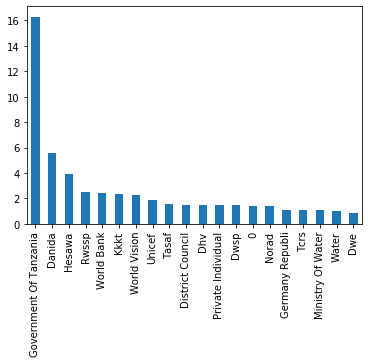

In [0]:
# https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/
series = pd.value_counts(df_train.funder)

# % of each of the sub-category
sub = (series/series.sum() * 100)
# sub-categories which have instances greater than 1
sub[0:20].plot(kind = 'bar')

## Similar Variables -- should choose one from each of these 

extraction  = 'extraction_type','extraction_type_group','extraction_type_class'

management =  'management', 'management_group'

payment ='payment', 'payment_type'                                  # these look the same 

water quality = 'water_quality', 'quality_group'

quantity = 'quantity', 'quantity_group'                      # these look exactly the same 

source = 'source', 'source_type', 'source_class'

waterpoint_type = 'waterpoint_type', 'waterpoint_type_group'

scheme = 'scheme_management', 'scheme_name'

In [0]:

# Check the number of null values across the three main class labels 

# -- create df with true-false assignments for missing values
# -- group the df by the three status labels 
# -- sum across the rows for each of those groups 
# -- display only columns which have null values 

cols = df_train.columns
df_train.isnull().groupby(df_train['status_group']).sum()[null_cols]

,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
status_group,,,,,,,
functional,1981.0,2000.0,205.0,1678.0,1873.0,14488.0,1673.0
functional needs repair,437.0,440.0,1.0,156.0,223.0,2004.0,300.0
non functional,1217.0,1215.0,165.0,1500.0,1781.0,11674.0,1083.0


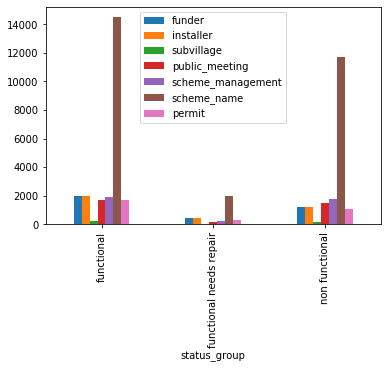

In [0]:
%matplotlib inline

# Plotting missing values 

df_train.isnull().groupby(df_train['status_group']).sum()[null_cols].plot(kind='bar')

##scheme name seems most problematic for all three categories 

In [0]:
# The feature 'scheme_name' seems to have the maximum missing values in all 3 categoreies 
# -- we will drop this variable
# -- we drop scheme_management   -- similar to management 
# -- we drop public_meeting

df_train = df_train.drop(['scheme_name','scheme_management','public_meeting'], axis=1)

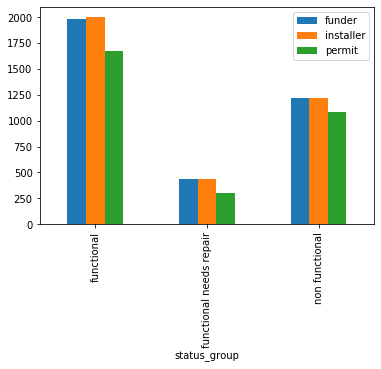

In [0]:
# Missing funder installer 
df_train.isnull().groupby(df_train['status_group']).sum()[['funder','installer','permit']].plot(kind='bar')

In [0]:
# For now dropping the funder, installer and subvillage columns -- would eventually like to use it 
df_train = df_train.drop(['funder','installer','subvillage'], axis=1)

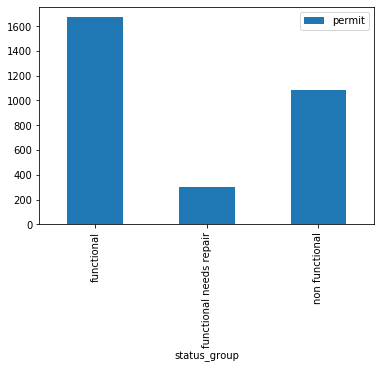

In [0]:
# Missing permit 
df_train.isnull().groupby(df_train['status_group']).sum()[['permit']].plot(kind='bar')

In [0]:
# isnull() dataframe and a series method --- inverse method notnull() 
# --- axis = 0 = do sum in the direction of the 0 axis/ across the rows/ down the columns
df_train.isnull().sum(axis=0)

# -- checking how many of these null valuses are in each of the subgroup labels
df_train.isnull().groupby(df_train['status_group']).sum()

# Dropping all the rows which has a missing value
df_train.dropna(how='any', inplace = True)

functional                 30586
non functional             21741
functional needs repair     4017
Name: status_group, dtype: int64


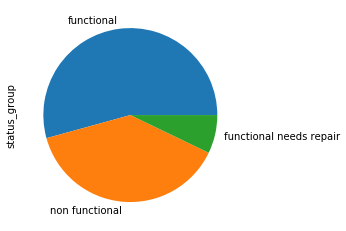

In [0]:
# observations under each category 

print(df_train['status_group'].value_counts())

df_train['status_group'].value_counts().plot(kind='pie')

# -- functional but needs repair has the least number of observations 

In [0]:
# create a copy df for analysis
# train2 only contains the features

feat_names = ['id', 'amount_tsh','gps_height','basin', 'region', 
             'population', 'permit', 'extraction_type_group', 
            'management', 'payment_type', 'quality_group', 
             'quantity', 'source']

df2 = df_train.loc[:, feat_names]

In [0]:
# Rename long column names 

df2.rename(columns={'extraction_type_group':'extraction',
                       'payment_type':'payment',
                       'quality_group': 'quality'}, inplace=True)

In [0]:
df2.head()

,id,amount_tsh,gps_height,basin,region,population,permit,extraction,management,payment,quality,quantity,source
0,69572,6000.0,1390,Lake Nyasa,Iringa,109,False,gravity,vwc,annually,good,enough,spring
1,8776,0.0,1399,Lake Victoria,Mara,280,True,gravity,wug,never pay,good,insufficient,rainwater harvesting
2,34310,25.0,686,Pangani,Manyara,250,True,gravity,vwc,per bucket,good,enough,dam
3,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,58,True,submersible,vwc,never pay,good,dry,machine dbh
4,19728,0.0,0,Lake Victoria,Kagera,0,True,gravity,other,never pay,good,seasonal,rainwater harvesting


In [0]:
# create dummy variales for all the categorical data 

df2 = pd.get_dummies(df2, drop_first=True)

In [0]:
df2.head()

,id,amount_tsh,gps_height,population,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,...,management_wug,payment_monthly,payment_never pay,payment_on failure,payment_other,payment_per bucket,payment_unknown,quality_fluoride,quality_good,quality_milky,quality_salty,quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown
0,69572,6000.0,1390,109,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,8776,0.0,1399,280,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,34310,25.0,686,250,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,67743,0.0,263,58,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,19728,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [0]:
# creating numerical labels for the target: functional -- 0; functional needs repair -- 1; non functional -- 2

y2 = df_train.loc[:,['status_group']]
y2 = y2['status_group'].astype('category').cat.codes

In [0]:
# Adding converted labels to df2

df2['status_group']=y2.tolist()

In [0]:
# creating a test and train set by splitting the data into 80:20 ratio 
# y contains all the labels 
# x contains all the features 

y = df2.status_group
x = df2.drop('status_group',axis=1)

# splitting 
# x_train and y_train contains the training data 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [0]:
# Since there is class imbalance -- undersample from the train data to make the ratio of all classes equal
# there are 3246 observations in the smallest class -- 1 -- functional but needs repair 

y_train.value_counts()

0    24455
2    17374
1     3246
Name: status_group, dtype: int64

#Classification 

##Models Used:

1. Logistic Regression
2. Support Vetcor Machine
3. K-Nearest Neighbor Classifier
4. Decision Tree Classifier 




In [0]:
import numpy as np
class_names = np.unique(df_train.status_group)

Logistic Regression Training Accuracy:0.6739
Logistic Regression Test Accuracy:0.6734


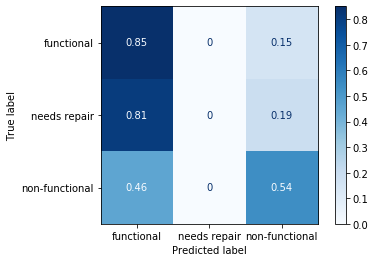

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt

logreg = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter = 1000)
logreg.fit(x_train,y_train)
logreg_pred = logreg.predict(x_test)
print("Logistic Regression Training Accuracy:{:.4f}".format(logreg.score(x_train,y_train)))
print("Logistic Regression Test Accuracy:{:.4f}".format(logreg.score(x_test,y_test)))

class_names = ['functional','needs repair','non-functional']
disp = plot_confusion_matrix(logreg, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
#disp.ax_.set_title(title)
plt.show()

Support Vector Machine Training Accuracy:0.4977
Support Vector Machine Test Accuracy:0.5026


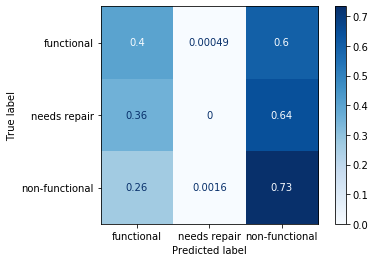

In [0]:
# Support Vector Machine
from sklearn.linear_model import SGDClassifier

svmc = SGDClassifier(random_state=1)
svmc.fit(x_train,y_train)

print("Support Vector Machine Training Accuracy:{:.4f}".format(svmc.score(x_train,y_train)))
print("Support Vector Machine Test Accuracy:{:.4f}".format(svmc.score(x_test,y_test)))

disp = plot_confusion_matrix(svmc, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
#disp.ax_.set_title(title)
plt.show()

K-Nearest Neighbor Training Accuracy:0.6292
K-Nearest Neighbor Test Accuracy:0.5331


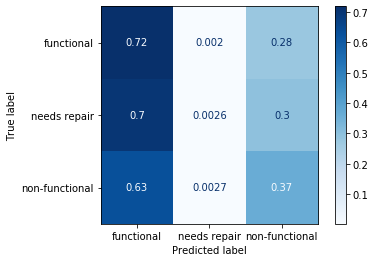

In [0]:
# K-Nearest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train,y_train)

print("K-Nearest Neighbor Training Accuracy:{:.4f}".format(knn.score(x_train,y_train)))
print("K-Nearest Neighbor Test Accuracy:{:.4f}".format(knn.score(x_test,y_test)))

disp = plot_confusion_matrix(knn, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

Decision Trees Classifier Train Accuracy:0.8842
Decision Trees Classifier Test Accuracy:0.7284


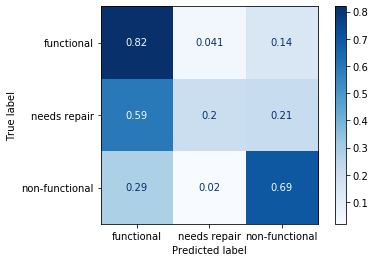

In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=20)
dt.fit(x_train,y_train)

print("Decision Trees Classifier Train Accuracy:{:.4f}".format(dt.score(x_train,y_train)))
print("Decision Trees Classifier Test Accuracy:{:.4f}".format(dt.score(x_test,y_test)))

disp = plot_confusion_matrix(dt, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

## Ensemble Models 

1. Random Forests Classifier
2. Voting Classifier 
3. Bagging Classifier


Random Forest Train Accuracy:0.9001
Random Forest Test Accuracy:0.7738


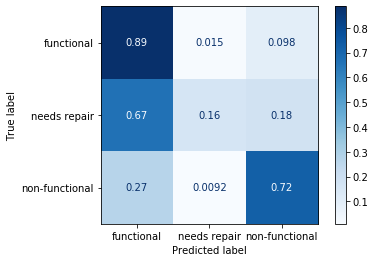

In [0]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(n_estimators=900, max_depth=20)
randomforest.fit(x_train,y_train)

print("Random Forest Train Accuracy:{:.4f}".format(randomforest.score(x_train,y_train)))
print("Random Forest Test Accuracy:{:.4f}".format(randomforest.score(x_test,y_test)))

disp = plot_confusion_matrix(randomforest, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

Ensemble: Voting Classifier Train Accuracy:0.8564
Ensemble: Voting Classifier Test Accuracy:0.7452


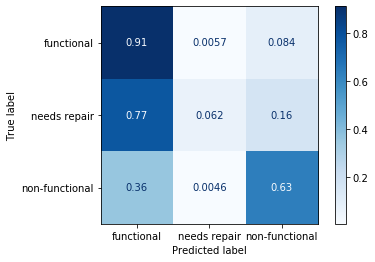

In [0]:
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

et = ExtraTreesClassifier()

voting = VotingClassifier(estimators=[('1',logreg),('2',svmc),('3',knn),('4',dt),('5',et),('6',randomforest)], voting='hard')
voting.fit(x_train,y_train)

print("Ensemble: Voting Classifier Train Accuracy:{:.4f}".format(voting.score(x_train,y_train)))
print("Ensemble: Voting Classifier Test Accuracy:{:.4f}".format(voting.score(x_test,y_test)))

disp = plot_confusion_matrix(voting, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show() 

Ensemble: Bagging Classifier Train Accuracy:0.9229
Ensemble: Bagging Classifier Test Accuracy:0.7664


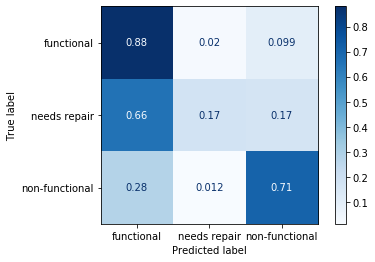

In [0]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20, random_state=1), n_estimators=500, bootstrap=True, random_state=1)
bagging.fit(x_train, y_train)

print("Ensemble: Bagging Classifier Train Accuracy:{:.4f}".format(bagging.score(x_train,y_train)))
print("Ensemble: Bagging Classifier Test Accuracy:{:.4f}".format(bagging.score(x_test,y_test)))

disp = plot_confusion_matrix(bagging, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

##Undersampling

In [0]:
# Undersample Data Points

x = pd.concat(([x_train,y_train]), axis=1)

func = x[x.status_group==0]
func_repair = x[x.status_group==1]
nonfunc = x[x.status_group==2]

sample0 = resample(func,replace=False, n_samples=len(func_repair), random_state=11)
sample2 = resample(nonfunc,replace=False, n_samples=len(func_repair), random_state=11)

sampled = pd.concat([sample0, func_repair, sample2])

sampled.status_group.value_counts()
sampled_y = sampled.status_group
sampled_x = sampled.drop('status_group',axis=1)

Random Forest Train Accuracy:0.9655
Random Forest Test Accuracy:0.6453


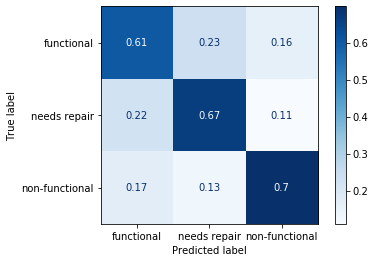

In [0]:
randomforest = RandomForestClassifier(n_estimators=900, max_depth=20)
randomforest.fit(sampled_x,sampled_y)

print("Random Forest Train Accuracy:{:.4f}".format(randomforest.score(sampled_x,sampled_y)))
print("Random Forest Test Accuracy:{:.4f}".format(randomforest.score(x_test,y_test)))

disp = plot_confusion_matrix(randomforest, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

Ensemble: Bagging Classifier Train Accuracy:0.9749
Ensemble: Bagging Classifier Test Accuracy:0.6470


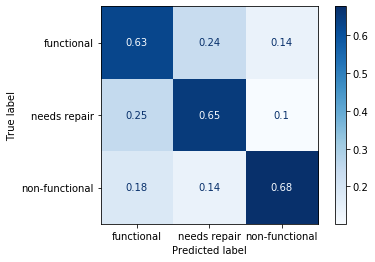

In [0]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20, random_state=1), n_estimators=500, bootstrap=True, random_state=1)
bagging.fit(sampled_x,sampled_y)

print("Ensemble: Bagging Classifier Train Accuracy:{:.4f}".format(bagging.score(sampled_x,sampled_y)))
print("Ensemble: Bagging Classifier Test Accuracy:{:.4f}".format(bagging.score(x_test,y_test)))

disp = plot_confusion_matrix(bagging, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

Oversampling

In [0]:
# Oversample Data Points

x = pd.concat(([x_train,y_train]), axis=1)

func = x[x.status_group==0]
func_repair = x[x.status_group==1]
nonfunc = x[x.status_group==2]

sample1 = resample(func_repair,replace=True, n_samples=len(func), random_state=11)
sample2 = resample(nonfunc,replace=True, n_samples=len(func), random_state=11)


sampled = pd.concat([func, sample1, sample2])

sampled.status_group.value_counts()

oversampled_y = sampled.status_group
oversampled_x = sampled.drop('status_group',axis=1)

In [0]:
sampled.status_group.value_counts()

Random Forest Train Accuracy:0.9318
Random Forest Test Accuracy:0.7325


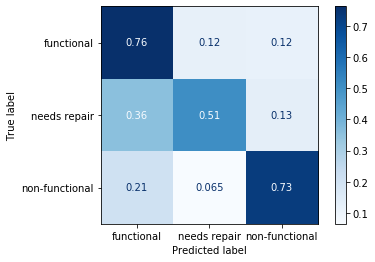

In [0]:
randomforest = RandomForestClassifier(n_estimators=900, max_depth=20)
randomforest.fit(oversampled_x,oversampled_y)

print("Random Forest Train Accuracy:{:.4f}".format(randomforest.score(oversampled_x,oversampled_y)))
print("Random Forest Test Accuracy:{:.4f}".format(randomforest.score(x_test,y_test)))

disp = plot_confusion_matrix(randomforest, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

Ensemble: Bagging Classifier Train Accuracy:0.9385
Ensemble: Bagging Classifier Test Accuracy:0.7280


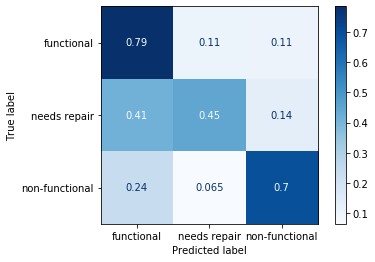

In [0]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20, random_state=1), n_estimators=500, bootstrap=True, random_state=1)
bagging.fit(oversampled_x,oversampled_y)

print("Ensemble: Bagging Classifier Train Accuracy:{:.4f}".format(bagging.score(oversampled_x,oversampled_y)))
print("Ensemble: Bagging Classifier Test Accuracy:{:.4f}".format(bagging.score(x_test,y_test)))

disp = plot_confusion_matrix(bagging, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

## SMOTE Sampling Analysis

In [0]:
# SMOTE Analysis
from imblearn.over_sampling import SMOTE

smt = SMOTE()
smote_x, smote_y = smt.fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [0]:
np.bincount(smote_y)

array([24455, 24455, 24455])

Random Forest Train Accuracy:0.9231
Random Forest Test Accuracy:0.7731


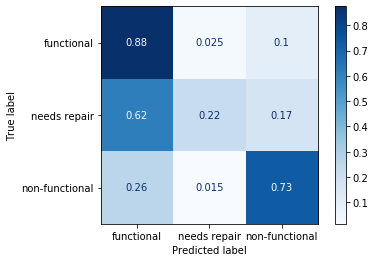

In [0]:
randomforest = RandomForestClassifier(n_estimators=900, max_depth=20)
randomforest.fit(smote_x, smote_y)

print("Random Forest Train Accuracy:{:.4f}".format(randomforest.score(smote_x, smote_y)))
print("Random Forest Test Accuracy:{:.4f}".format(randomforest.score(x_test,y_test)))

disp = plot_confusion_matrix(randomforest, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

plt.show()

In [0]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20, random_state=1), n_estimators=500, bootstrap=True, random_state=1)
bagging.fit(smote_x, smote_y)

print("Ensemble: Bagging Classifier Train Accuracy:{:.4f}".format(bagging.score(smote_x, smote_y)))
print("Ensemble: Bagging Classifier Test Accuracy:{:.4f}".format(bagging.score(x_test,y_test)))

disp = plot_confusion_matrix(bagging, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show()